In [ ]:
#Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#Loading the LoadCNNModel.py in colab environment that contains the model definitions
!cp /content/drive/My\ Drive/LoadCNNModel.py /content

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import keras
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger,LearningRateScheduler
from tensorflow.keras.models import  load_model

from LoadCNNModel import loadDenseNetModel


In [ ]:
#To check if GPU is enables
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
BASE_PATH = '/content'
#Function for extracting dataset
def extract_dataset(path):
  

  zip_ref = zipfile.ZipFile(path, 'r')
  zip_ref.extractall(BASE_PATH)
  zip_ref.close()

In [ ]:
#Extracting the dataset
extract_dataset('/content/drive/My Drive/Research_Dataset/Dataset.zip')

In [ ]:
#Loading the train, test and validation image labels
train = pd.read_csv('/content/Dataset/train.csv')
test = pd.read_csv('/content/Dataset/test.csv')
val = pd.read_csv('/content/Dataset/val.csv')

In [ ]:
#Initializing the DenseNet model
model = loadDenseNetModel((224,224,3),3)

29089792/29084464 [==============================] - 1s 0us/step


In [ ]:
#Printing the model summary
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
'''
Image Data Generator for loading the images for Train, Test and Validation Images 

1. flow_from_dataframe() : loads the images listed in the dataframe loaded in the previous step
by extracting the image name mentioned in "x_col" and the labels are in the "y_col"
the path for the images are set in the "directory" argument.

2. The real time augmentation are specified in the ImageDataGenerator object created for training "dataGenerator".
'''
image_size = 224

dataGenerator = ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rotation_range=45,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=[0.3,0.6],
                                fill_mode='nearest',
                                shear_range=0.1,
                                rescale=1/255,
                                )#validation_split=0.2

test_Data_Generator = ImageDataGenerator(rescale=1/255)                                
trainGenerator = dataGenerator.flow_from_dataframe(train,
                                        directory='/content/Dataset/Train',
                                        target_size=(image_size, image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        subset='training',
                                        batch_size=32)
validGenerator =  test_Data_Generator.flow_from_dataframe(val,
                                        directory='/content/Dataset/Val',
                                        target_size=(image_size,image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)
test_gen = test_Data_Generator.flow_from_dataframe(test,
                                        directory='/content/Dataset/Test',
                                        target_size=(image_size,image_size),
                                        x_col="Image",
                                        y_col=['lung_aca','lung_n','lung_scc'],
                                        class_mode='raw',
                                        shuffle=False,
                                        batch_size=32)


In [ ]:
#Initilizing the optimizer 
adam = Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])

In [ ]:
#Initializing the callbacks
log = CSVLogger('/content/drive/My Drive/Research_Dataset/DenseNet121/DenseNet121.csv')
lr_decay = LearningRateScheduler(schedule=lambda epoch: 0.0001 * np.exp(-epoch / 10.))
mc = ModelCheckpoint('/content/drive/My Drive/Research_Dataset/DenseNet121/densenet121_model.h5',
                     monitor='val_accuracy',
                     mode='max', verbose=1, save_best_only=True)

In [ ]:
#Training the DenseNet model
train_step = trainGenerator.n//trainGenerator.batch_size
val_step = validGenerator.n//validGenerator.batch_size
history = model.fit_generator(generator=trainGenerator,
                                steps_per_epoch=train_step,
                                validation_data=validGenerator,
                                validation_steps=val_step,
                                epochs=30,callbacks=[log, mc,lr_decay])


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
299/299 [==============================] - ETA: 0s - loss: 0.1856 - accuracy: 0.9598
Epoch 00001: val_accuracy improved from -inf to 0.98333, saving model to /content/drive/My Drive/Research_Dataset/DenseNet121/densenet121_model.h5
299/299 [==============================] - 164s 548ms/step - loss: 0.1856 - accuracy: 0.9598 - val_loss: 0.0419 - val_accuracy: 0.9833
Epoch 2/30
299/299 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9917
Epoch 00002: val_accuracy improved from 0.98333 to 0.99875, saving model to /content/drive/My Drive/Research_Dataset/DenseNet121/densenet121_model.h5
299/299 [==============================] - 163s 544ms/step - loss: 0.0268 - accuracy: 0.9917 - val_loss: 0.0047 - val_accuracy: 0.9987
Epoch 3/30
299/299 [==============================] - ETA: 0s - loss: 0.0421 - accuracy: 0.9890
Epoch 00003: val_accuracy did not improve from 0.99875
299/299 [=====

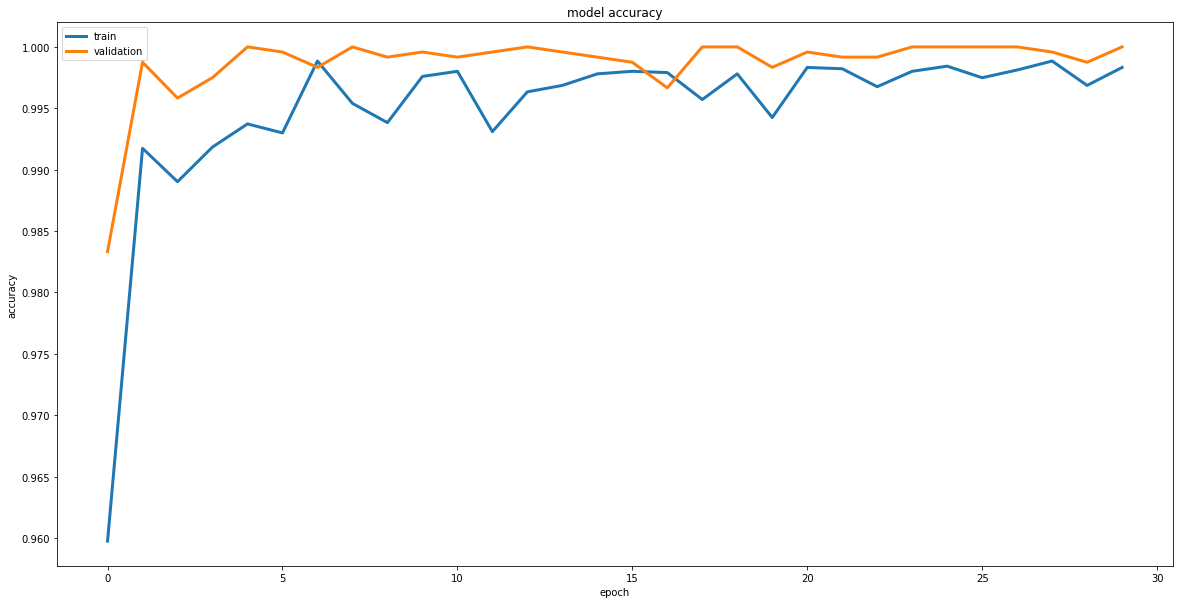

In [ ]:
#Plotting the train and validation accuracy curve
plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'],linewidth=3.0)
plt.plot(history.history['val_accuracy'],linewidth=3.0)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

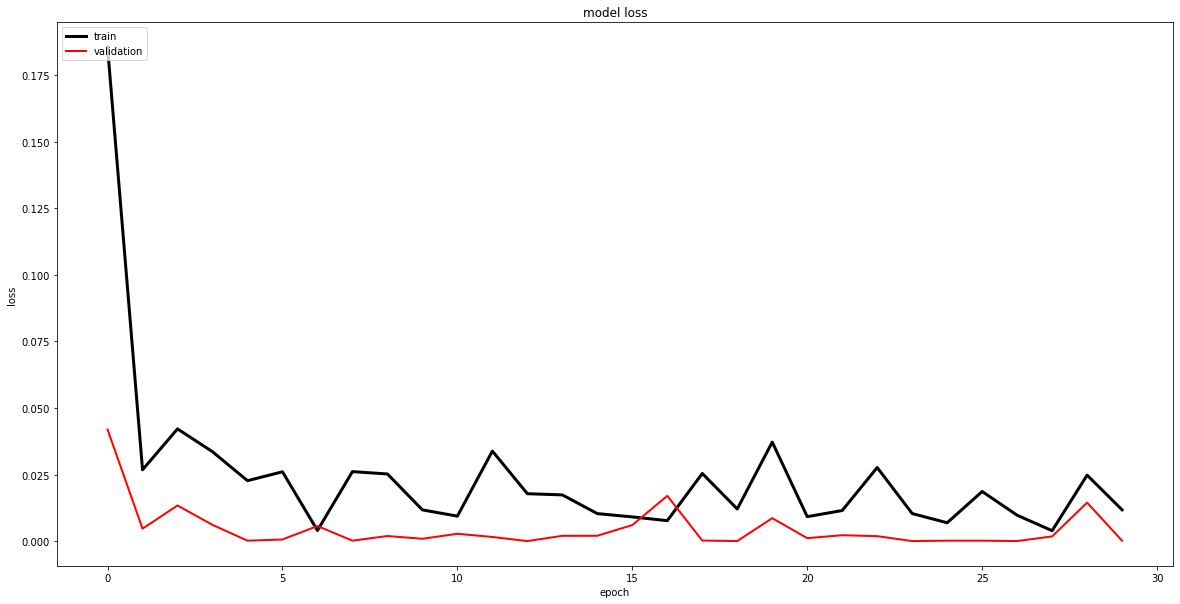

In [ ]:
#Plotting the training and validation loss curve
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'], color='black',linewidth=3.0)
plt.plot(history.history['val_loss'],color='red',linewidth=2.0)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#Loading the model for evaluation
from keras.models import  load_model
model = load_model('/content/drive/My Drive/Research_Dataset/DenseNet121/densenet121_model.h5')

In [ ]:
#Evaluating the test accuracy
test_pred = model.evaluate_generator(test_gen,verbose=1)
print("Testing Accuracy :"+str(test_pred[1]))

Instructions for updating:
Please use Model.evaluate, which supports generators.
94/94 [==============================] - 22s 236ms/step - loss: 0.0049 - accuracy: 0.9990
Testing Accuracy :0.9990000128746033


In [ ]:
#Extracting the prediction made by the model
testin_predictions = model.predict(test_gen,verbose=1)
testin_predictions[0]

94/94 [==============================] - 21s 224ms/step


array([1.0000000e+00, 1.3205918e-15, 6.2100568e-11], dtype=float32)

In [ ]:
testin_predictionsb = (testin_predictions>0.5)
testin_predictionsb[0]

array([ True, False, False])

### Converting the prediction into string labels

The predictions are converted from label encodings to actual string labels.
"result" dataframe is created which has the predictied values


In [ ]:
predictions = testin_predictionsb.astype(int)

In [ ]:
columns = ['lung_aca','lung_n','lung_scc']

results = pd.DataFrame(predictions, columns=columns)
results['Image'] = test_gen.filenames
ordered_cols = ['Image'] + columns
results = results[ordered_cols]
results.head()

,Image,lung_aca,lung_n,lung_scc
0,lungaca1295.jpeg,1,0,0
1,lungaca249.jpeg,1,0,0
2,lungscc2058.jpeg,0,0,1
3,lungn4006.jpeg,0,1,0
4,lungn3434.jpeg,0,1,0


In [ ]:
'''
The "Predicted_CancerType" column of the "result" dataframe contains the
predicted cancer type.
'''
results['Image'] = test_gen.filenames
results.insert(4,'Predicted_CancerType', '', False)
ordered_cols = ['Image'] + columns + ['Predicted_CancerType']
results = results[ordered_cols]

for i in range(len(results)):
  if results.at[i,'lung_aca'] == 1:
    results.at[i,'Predicted_CancerType'] = 'lung_aca'
  elif results.at[i,'lung_n'] == 1:
    results.at[i,'Predicted_CancerType'] = 'lung_n'
  else:
    results.at[i,'Predicted_CancerType'] = 'lung_scc'

results.head()

,Image,lung_aca,lung_n,lung_scc,Predicted_CancerType
0,lungaca1295.jpeg,1,0,0,lung_aca
1,lungaca249.jpeg,1,0,0,lung_aca
2,lungscc2058.jpeg,0,0,1,lung_scc
3,lungn4006.jpeg,0,1,0,lung_n
4,lungn3434.jpeg,0,1,0,lung_n


In [ ]:
print(list(test['CancerType']))
print(list(results['Predicted_CancerType']))

['lung_aca', 'lung_aca', 'lung_scc', 'lung_n', 'lung_n', 'lung_n', 'lung_n', 'lung_scc', 'lung_n', 'lung_n', 'lung_scc', 'lung_n', 'lung_n', 'lung_aca', 'lung_n', 'lung_aca', 'lung_n', 'lung_scc', 'lung_aca', 'lung_n', 'lung_n', 'lung_aca', 'lung_scc', 'lung_n', 'lung_scc', 'lung_aca', 'lung_scc', 'lung_aca', 'lung_scc', 'lung_n', 'lung_aca', 'lung_aca', 'lung_scc', 'lung_n', 'lung_scc', 'lung_aca', 'lung_n', 'lung_aca', 'lung_aca', 'lung_n', 'lung_scc', 'lung_n', 'lung_aca', 'lung_scc', 'lung_n', 'lung_scc', 'lung_scc', 'lung_aca', 'lung_n', 'lung_n', 'lung_n', 'lung_aca', 'lung_n', 'lung_aca', 'lung_scc', 'lung_scc', 'lung_n', 'lung_aca', 'lung_scc', 'lung_aca', 'lung_n', 'lung_aca', 'lung_scc', 'lung_n', 'lung_n', 'lung_n', 'lung_aca', 'lung_n', 'lung_aca', 'lung_scc', 'lung_scc', 'lung_aca', 'lung_n', 'lung_n', 'lung_scc', 'lung_aca', 'lung_n', 'lung_n', 'lung_aca', 'lung_aca', 'lung_aca', 'lung_n', 'lung_aca', 'lung_aca', 'lung_n', 'lung_n', 'lung_n', 'lung_scc', 'lung_aca', 'lung

In [ ]:
#Estimation of the Matthew's Correlation Coefficient
mcc = metrics.matthews_corrcoef(test['CancerType'], results['Predicted_CancerType'])
print("Matthews Correlation Coefficient: ", mcc)

Matthews Correlation Coefficient:  0.9985000011847723


In [ ]:
#Estimation of the F1 Score
print(metrics.classification_report(test['CancerType'], results['Predicted_CancerType'],columns))

              precision    recall  f1-score   support

    lung_aca       1.00      1.00      1.00       980
      lung_n       1.00      1.00      1.00      1017
    lung_scc       1.00      1.00      1.00      1003

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [ ]:
#Generating the confusion matrix
confusion_mtx = metrics.confusion_matrix(test['CancerType'], results['Predicted_CancerType'],columns)
confusion_mtx.T

array([[ 979,    1,    1],
       [   0, 1016,    0],
       [   1,    0, 1002]])

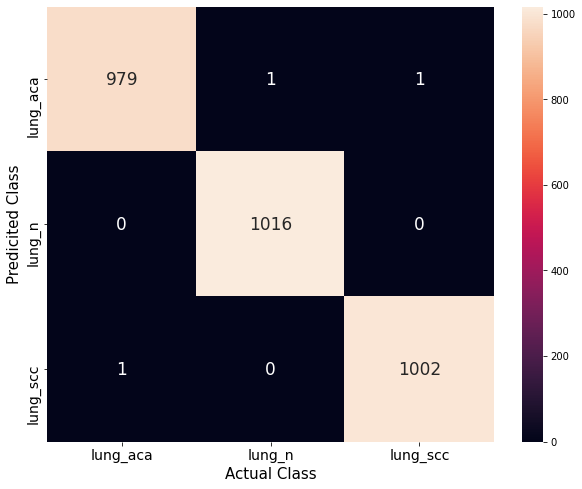

In [ ]:
#plotting the confusion matrix
plt.figure(figsize=(10,8))
ax= plt.subplot()
sns.heatmap(confusion_mtx.T, annot=True, ax = ax,fmt='g',annot_kws={"size": 17})
ax.xaxis.set_ticklabels(columns)
ax.yaxis.set_ticklabels(columns)
ax.xaxis.label.set_fontsize(15)
ax.yaxis.label.set_fontsize(15)
ax.set_xlabel('Actual Class')
ax.set_ylabel('Predicited Class')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()